In [1]:
import os
import torch
from torch import nn
from poutyne import Model, CSVLogger
from poutyne.framework import ModelCheckpoint, EarlyStopping, plot_history
import numpy as np
import torchmetrics
from datetime import datetime
import sys
import pandas as pd
from custom_lib.custom_models.basic_nn import NeuralNetwork
from custom_lib.data_prep import data_transformation_pipeline, data_loader
import matplotlib as plt
import torchvision.models as models
import time


In [2]:
# These need to be passed in a parse args statement
# Tuneable Params
lr = 1e-3
data_dir = "data"
model_name = "b0"
save_logs = True
epochs = 15
rotate_angle=None
horizontal_flip_prob=None
brightess_contrast=None
gaussian_blur=None
normalize=True
seed = 42
batch_size = 32
results_folder_name = "trunc_results"
truncated_layers = 1
bootstrap_n = 200



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [4]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights, EfficientNet_B3_Weights

# Define the model mapping as a constant (outside the function)
MODEL_MAPPING = {
    "b0": ("efficientnet_b0", EfficientNet_B0_Weights.IMAGENET1K_V1),
    "b1": ("efficientnet_b1", EfficientNet_B1_Weights.IMAGENET1K_V1),
    "b2": ("efficientnet_b2", EfficientNet_B2_Weights.IMAGENET1K_V1),
    "b3": ("efficientnet_b3", EfficientNet_B3_Weights.IMAGENET1K_V1),
}

def load_efficientnet(model_name, model_mapping):
    """
    Load an EfficientNet model based on the provided model name and model mapping.

    Args:
        model_name (str): The name of the EfficientNet model (e.g., "b0", "b1", "b2", "b3").
        model_mapping (dict): A dictionary mapping model names to their corresponding classes and weights.

    Returns:
        torch.nn.Module: The loaded EfficientNet model.

    Raises:
        ValueError: If the model name is not supported.
    """
    # Check if the model name is valid
    if model_name not in model_mapping:
        raise ValueError(f"Unsupported model name: {model_name}. Supported models are: {list(model_mapping.keys())}")

    # Get the model class and weights from the mapping
    model_class_name, weights = model_mapping[model_name]
    model_class = getattr(models, model_class_name)

    # Load the model with pretrained weights
    effnet = model_class(weights=weights)
    return effnet


try:
    effnet = load_efficientnet(model_name, MODEL_MAPPING)
    print(f"Successfully loaded EfficientNet {model_name}.")
except ValueError as e:
    print(e)

Successfully loaded EfficientNet b0.


In [5]:
if model_name == "b0":
    image_size = 224
if model_name == "b1":
    image_size = 240
if model_name == "b2":
    image_size = 260
if model_name == "b3":
    image_size = 300

In [6]:
train_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=True)
test_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)
val_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)

train_loader , val_loader, test_loader, num_classes = data_loader(data_dir, 
                                                     train_transform=train_transform,
                                                     test_transform=test_transform,
                                                     val_transform=val_transform,
                                                     seed=seed,
                                                     batch_size=batch_size
                                                     )


Train size: 6177, Validation size: 772, Test size: 773


In [7]:


class TruncatedEffNet(nn.Module):
    def __init__(self, effnet, num_classes, removed_layers, batch_size, image_size):
        super(TruncatedEffNet, self).__init__()

        # Truncate the EfficientNet backbone
        layers = 7 - removed_layers
        self.effnet_truncated = nn.Sequential(*list(effnet.features.children())[:layers])

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Dynamically calculate the input size for the fully connected layer
        with torch.no_grad():  # Disable gradient tracking for this forward pass
            dummy_input = torch.randn(batch_size, 3, image_size, image_size)  # Example input (batch_size=1, channels=3, height=224, width=224)
            dummy_output = self.effnet_truncated(dummy_input)
            dummy_output = self.global_avg_pool(dummy_output)
            fc_input_size = dummy_output.view(dummy_output.size(0), -1).size(1)  # Flatten and get the size

        # Define the fully connected layer
        self.fc = nn.Linear(fc_input_size, num_classes)

    def forward(self, x):
        x = self.effnet_truncated(x)  # Extract features
        x = self.global_avg_pool(x)  # Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Classification
        return x

# Instantiate the model with the truncated backbone
model = TruncatedEffNet(effnet, num_classes, removed_layers=truncated_layers, batch_size=batch_size, image_size=image_size)

In [8]:
if save_logs:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    # Create directory for saving all logs and model outputs 
    results_dir = os.path.join(f"{results_folder_name}/{model_name}_reduced_layers_{truncated_layers}_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)
    print(f"Logs and output will be saved in: {results_dir}")


Logs and output will be saved in: trunc_results/b0_2025-02-06_17-46


In [9]:


# 6. Wrap the model with Poutyne
poutyne_model = Model(
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=lr),
    loss_function=nn.CrossEntropyLoss(),
    batch_metrics=["accuracy"],
    device=device
)

In [10]:

callbacks = None

if save_logs == True:
    # Callback: Save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(f"{results_dir}/best_model.pth", monitor='val_loss', mode='min', save_best_only=True)
    csv_logger = CSVLogger(f"{results_dir}/training_logs.csv")
    callbacks = [checkpoint, csv_logger]

start_time = time.time()
# 7. Train the model
history = poutyne_model.fit_generator(train_loader, val_loader, epochs=epochs, verbose=True,
                            callbacks = callbacks)
end_time = time.time()

run_time = end_time - start_time

print(f"Model training took {run_time / 60} minutes")


# Save the final model manually
torch.save(poutyne_model.network.state_dict(), f"{results_dir}/final_model.pth")

Epoch:  1/15 Train steps: 194 Val steps: 13 1m37.81s loss: 0.158692 acc: 94.285252 val_loss: 0.106141 val_acc: 96.891192
Epoch:  2/15 Train steps: 194 Val steps: 13 1m35.48s loss: 0.059135 acc: 98.089688 val_loss: 0.034397 val_acc: 98.704663
Epoch:  3/15 Train steps: 194 Val steps: 13 1m35.43s loss: 0.039623 acc: 98.656306 val_loss: 0.020310 val_acc: 99.611399
Epoch:  4/15 Train steps: 194 Val steps: 13 1m35.67s loss: 0.037682 acc: 98.656306 val_loss: 0.039759 val_acc: 98.704663
Epoch:  5/15 Train steps: 194 Val steps: 13 1m35.54s loss: 0.027692 acc: 99.012466 val_loss: 0.051499 val_acc: 98.316062
Epoch:  6/15 Train steps: 194 Val steps: 13 1m35.59s loss: 0.029131 acc: 99.044844 val_loss: 0.037102 val_acc: 98.963731
Epoch:  7/15 Train steps: 194 Val steps: 13 1m35.38s loss: 0.019651 acc: 99.384815 val_loss: 0.037445 val_acc: 99.093264
Epoch:  8/15 Train steps: 194 Val steps: 13 1m35.13s loss: 0.017445 acc: 99.546706 val_loss: 0.028412 val_acc: 99.093264
Epoch:  9/15 Train steps: 194 Va

In [11]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Subset
from poutyne import Model
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

def bootstrap_evaluation_poutyne(model, test_loader, save_logs, results_dir, n_bootstraps=1000, seed=42):
    """
    Perform bootstrap evaluation of a model on a test dataset.

    Args:
        model: The trained Poutyne model to evaluate.
        test_loader: DataLoader for the test dataset.
        save_logs: Whether to save the metric distributions to CSV.
        results_dir: Directory to save the bootstrap distribution CSV.
        n_bootstraps: Number of bootstrap samples to generate.
        seed: Random seed for reproducibility.

    Returns:
        A pandas DataFrame with mean and confidence intervals for:
        - Accuracy
        - F1 Score
        - Sensitivity (Recall)
        - Specificity
        - Test Loss
    """
    rng = np.random.RandomState(seed)

    # Store bootstrapped metrics
    metrics = {
        "accuracy": [],
        "f1_score": [],
        "sensitivity": [],
        "specificity": [],
        "loss": [],
    }

    for _ in range(n_bootstraps):
        sampled_indices = rng.choice(len(test_loader.dataset), len(test_loader.dataset), replace=True)
        sampled_subset = Subset(test_loader.dataset, sampled_indices)
        sampled_loader = DataLoader(sampled_subset, batch_size=test_loader.batch_size, shuffle=False)

        # Evaluate using Poutyne
        test_loss, test_acc = model.evaluate_generator(sampled_loader)

        # Extract predictions and true labels
        y_true, y_pred = [], []
        for inputs, labels in sampled_loader:
            outputs = model.predict_on_batch(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(np.argmax(outputs, axis=1))

        # Compute metrics
        f1 = f1_score(y_true, y_pred, average='macro')
        sensitivity = recall_score(y_true, y_pred, average='macro')

        # Compute specificity
        cm = confusion_matrix(y_true, y_pred)
        specificity_values = []
        for i in range(cm.shape[0]):
            col_sum = cm[:, i].sum()
            if col_sum > 0:
                specificity_values.append(cm[i, i] / col_sum)
        specificity = np.mean(specificity_values) if specificity_values else 0.0

        # Store results
        metrics["accuracy"].append(test_acc)
        metrics["f1_score"].append(f1)
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)
        metrics["loss"].append(test_loss)

    if save_logs:
        # Save the full bootstrap distributions
        dist_df = pd.DataFrame(metrics)
        dist_df.to_csv(f"{results_dir}/bootstrap_distribution.csv", index=False)

    # Compute mean and confidence intervals
    def compute_ci(values):
        return np.mean(values), np.percentile(values, 2.5), np.percentile(values, 97.5)

    results_dict = {f"{metric}_{stat}": value
                    for metric, values in metrics.items()
                    for stat, value in zip(["mean", "low", "high"], compute_ci(values))}

    # Convert to DataFrame
    results_df = pd.DataFrame([results_dict])

    return results_df


In [12]:

# # Run bootstrapping evaluation with your Poutyne model
boot_strap_results = bootstrap_evaluation_poutyne(poutyne_model, test_loader, n_bootstraps = bootstrap_n, save_logs=True, results_dir=results_dir)


Test steps: 13 3.40s test_loss: 0.043834 test_acc: 99.094437                                 
Test steps: 13 1.94s test_loss: 0.034530 test_acc: 99.094437                                 
Test steps: 13 1.90s test_loss: 0.043020 test_acc: 98.706339                                 
Test steps: 13 1.84s test_loss: 0.028326 test_acc: 99.223803                                 
Test steps: 13 1.87s test_loss: 0.017271 test_acc: 99.482536                                 
Test steps: 13 1.88s test_loss: 0.033477 test_acc: 99.223803                                 
Test steps: 13 1.88s test_loss: 0.022130 test_acc: 99.482536                                 
Test steps: 13 1.91s test_loss: 0.042240 test_acc: 98.965071                                 
Test steps: 13 1.90s test_loss: 0.023263 test_acc: 99.223803                                 
Test steps: 13 1.90s test_loss: 0.034141 test_acc: 99.094437                                 
Test steps: 13 1.91s test_loss: 0.031667 test_acc: 99.223803

In [13]:
boot_strap_results

,accuracy_mean,accuracy_low,accuracy_high,f1_score_mean,f1_score_low,f1_score_high,sensitivity_mean,sensitivity_low,sensitivity_high,specificity_mean,specificity_low,specificity_high,loss_mean,loss_low,loss_high
0,99.141656,98.447607,99.615136,0.990268,0.98258,0.995822,0.990055,0.982396,0.995739,0.990645,0.983243,0.996041,0.031256,0.01069,0.056805


/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


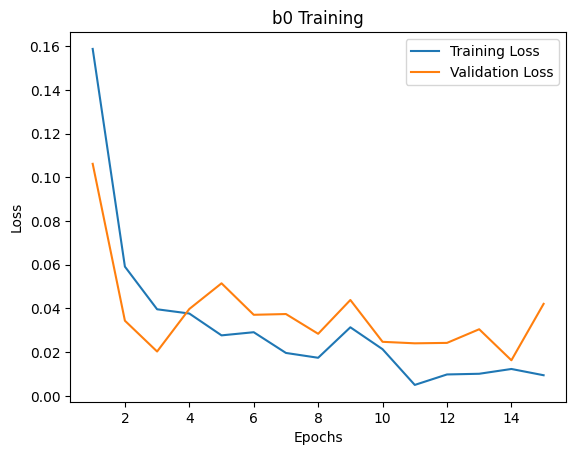

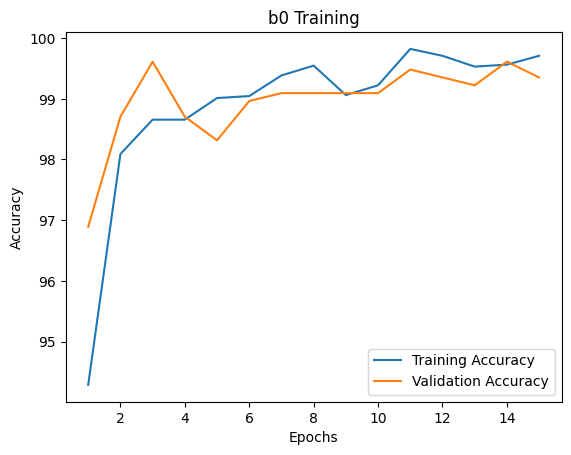

In [14]:
# Save logs and plots
if save_logs:
    with open(f"{results_dir}/model_overview.txt", "w") as file:
        file.write(f"Model Structure:\n{model}\n")
        file.write(f"Using {device} device\n")

# Check if CSV exists
    if os.path.exists(f"{results_folder_name}/test_results.csv"):
        test_results_df = pd.read_csv(f"{results_folder_name}/test_results.csv")
    else:
        test_results_df = pd.DataFrame(columns=[
            "model_id", "model", "epochs", "run_time", "lr", "image_size",
            "rotate_angle", "horizontal_flip_prob", "gaussian_blur", "normalize", "seed", "truncated_layers"
        ])

    # Create a DataFrame for the new model's metadata
    new_results_df = pd.DataFrame({
        "model_id": [f"{model_name}_{timestamp}"],
        "model": [model_name],
        "truncated_layers": [truncated_layers],
        "epochs": [epochs],  
        "run_time": [run_time / 60],  
        "lr": [lr],
        "image_size": [image_size],  
        "rotate_angle": [rotate_angle],  
        "horizontal_flip_prob": [horizontal_flip_prob],  
        "gaussian_blur": [gaussian_blur],  
        "normalize": [normalize],
        "seed": [seed],
    })

    # Combine test metadata with bootstrapped results (column-wise merge)
    new_results_df = pd.concat([new_results_df, boot_strap_results], axis=1)

    # Append to existing DataFrame
    test_results_df = pd.concat([test_results_df, new_results_df], ignore_index=True)

    # Save updated results
    test_results_df.to_csv(f"{results_folder_name}/test_results.csv", index=False)

    # Plot training history
    plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",
        save=True,  
        save_filename_template='{metric}_plot',  
        save_directory=results_dir,  
        save_extensions=('png',)  
    )
